##Getting Kaggel Data

In [1]:
!pip install kaggle

In [2]:
!kaggle competitions download -c dogs-vs-cats

100% 811M/812M [00:08<00:00, 56.0MB/s]
100% 812M/812M [00:08<00:00, 103MB/s] 


In [3]:
!mkdir dogs_vs_cats
!unzip dogs-vs-cats.zip -d dogs_vs_cats

Archive:  dogs-vs-cats.zip
  inflating: dogs_vs_cats/sampleSubmission.csv  
  inflating: dogs_vs_cats/test1.zip  
  inflating: dogs_vs_cats/train.zip  


In [4]:
!unzip dogs_vs_cats/train.zip -d /content/dogs_vs_cats

Streaming output truncated to the last 5000 lines.
  inflating: /content/dogs_vs_cats/train/dog.5499.jpg  
  inflating: /content/dogs_vs_cats/train/dog.55.jpg  
  inflating: /content/dogs_vs_cats/train/dog.550.jpg  
  inflating: /content/dogs_vs_cats/train/dog.5500.jpg  
  inflating: /content/dogs_vs_cats/train/dog.5501.jpg  
  inflating: /content/dogs_vs_cats/train/dog.5502.jpg  
  inflating: /content/dogs_vs_cats/train/dog.5503.jpg  
  inflating: /content/dogs_vs_cats/train/dog.5504.jpg  
  inflating: /content/dogs_vs_cats/train/dog.5505.jpg  
  inflating: /content/dogs_vs_cats/train/dog.5506.jpg  
  inflating: /content/dogs_vs_cats/train/dog.5507.jpg  
  inflating: /content/dogs_vs_cats/train/dog.5508.jpg  
  inflating: /content/dogs_vs_cats/train/dog.5509.jpg  
  inflating: /content/dogs_vs_cats/train/dog.551.jpg  
  inflating: /content/dogs_vs_cats/train/dog.5510.jpg  
  inflating: /content/dogs_vs_cats/train/dog.5511.jpg  
  inflating: /content/dogs_vs_cats/train/dog.5512.jpg  
 

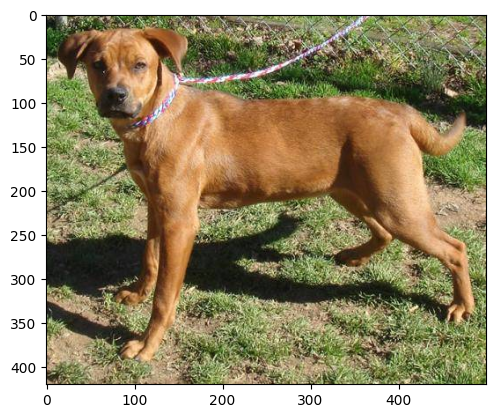

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img = mpimg.imread('dogs_vs_cats/train/dog.55.jpg')
imgplot = plt.imshow(img)
plt.show()

## Setting Config

In [6]:
IMAGES_PATH = "/content/dogs_vs_cats/train/"

NUM_CLASSES = 2
NUM_VAL_IMAGES = 1250 * NUM_CLASSES
NUM_TEST_IMAGES = 1250 * NUM_CLASSES

TRAIN_HDF5 = "/content/dogs_vs_cats_train.hdf5"
VAL_HDF5 = "/content/dogs_vs_cats_val.hdf5"
TEST_HDF5 = "/content/dogs_vs_cats_test.hdf5"

MODEL_PATH = "/content/alexnet_dogs_vs_cats.keras"
DATASET_MEAN = "/content/dogs_vs_cats_mean.json"
OUTPUT_PATH = "/content/"


## Importing Modules

In [8]:
from keras import Sequential
from keras.layers import RandomRotation, RandomTranslation, RandomZoom, RandomFlip
# from keras_cv.layers import RandomShear
from keras.optimizers import Adam
import json
import os


## Defining Classes and Functions

###ImageToArrayPreprocessor

In [9]:
from keras.preprocessing.image import img_to_array


class ImageToArrayPreprocessor:
    def __init__(self, data_format=None):
        self.data_format = data_format

    def preprocess(self, image):
        return img_to_array(image, data_format=self.data_format)

###AspectAwarePreprocessor

In [10]:
import imutils
import cv2


class AspectAwarePreprocessor:
    def __init__(self, width, height, inter=cv2.INTER_AREA):
        self.width = width
        self.height = height
        self.inter = inter

    def preprocess(self, image):
        (h, w) = image.shape[:2]
        dW = 0
        dH = 0

        # resize wrt shortest img dimension
        if w < h:
            image = imutils.resize(image, width=self.width, inter=self.inter)
            dH = int((image.shape[0] - self.height) / 2.0)
        else:
            image = imutils.resize(image, height=self.height, inter=self.inter)
            dW = int((image.shape[1] - self.width) / 2.0)

        # crop to achieve desired image size
        (h, w) = image.shape[:2]
        image = image[dH: h - dH, dW: w - dW]

        # resize again to ensure no rounding errors after cropping
        return cv2.resize(image, (self.width, self.height), interpolation=self.inter)


###SimplePreprocessor

In [11]:
import cv2


class SimplePreprocessor:
    def __init__(self, width: int, height: int, inter=cv2.INTER_AREA):
        # store target img width, height and interpolation
        # method used when resizing
        self.width = width
        self.height = height
        self.inter = inter

    def preprocess(self, image):
        # resize img to fixed size, ignore aspect ratio
        return cv2.resize(image, (self.width, self.height), interpolation=self.inter)

###PatchPreprocessor

In [12]:
from sklearn.feature_extraction.image import extract_patches_2d


class PatchPreprocessor:
    def __init__(self, width, height):
        self.width = width
        self.height = height

    def preprocess(self, image):
        return extract_patches_2d(image, (self.height, self.width), max_patches=1)[0]


###MeanPreprocessor

In [13]:
import cv2


class MeanPreprocessor:
    def __init__(self, r_mean, g_mean, b_mean):
        self.r_mean = r_mean
        self.g_mean = g_mean
        self.b_mean = b_mean

    def preprocess(self, image):
        (B, G, R) = cv2.split(image.astype("float32"))

        R -= self.r_mean
        G -= self.g_mean
        B -= self.b_mean

        return cv2.merge([B, G, R])


### CropPreprocessor

In [14]:
import numpy as np
import cv2


class CropPreprocessor:
    def __init__(self, width, height, horiz=True, inter=cv2.INTER_AREA):
        self.width = width
        self.height = height
        self.horiz = horiz
        self.inter = inter

    def preprocess(self, image):
        crops = []
        (h, w) = image.shape[:2]
        coords = [
            [0, 0, self.width, self.height],
            [w - self.width, 0, w, self.height],
            [w - self.width, h - self.height, w, h],
            [0, h - self.height, self.width, h]
        ]

        dW = int(0.5 * (w - self.width))
        dH = int(0.5 * (h - self.height))

        for (start_x, start_y, end_x, end_y) in coords:
            crop = image[start_y:end_y, start_x:end_x]
            crop = cv2.resize(crop, (self.width, self.height), interpolation=self.inter)
            crops.append(crop)

        if self.horiz:
            mirrors = [cv2.flip(c, 1) for c in crops]
            crops.extend(mirrors)

        return np.array(crops)

###TrainingMonitor

In [15]:
from keras.callbacks import TensorBoard
import matplotlib.pyplot as plt
import numpy as np
import os
import json


class TrainingMonitor(TensorBoard):
    def __init__(self, fig_path=None, json_path=None, start_at=0):
        super(TrainingMonitor, self).__init__()
        self.fig_path = fig_path
        self.json_path = json_path
        self. start_at = start_at

    def on_train_begin(self, logs={}):
        # initialize history dict
        self.H = {}

        if self.json_path:
            if os.path.exists(self.json_path):
                self.H = json.loads(open(self.json_path).read())

                # trim any entries that are past the starting epoch
                if self.start_at > 0:
                    for k in self.H.keys():
                        self.H[k] = self.H[k][:self.start_at]

    def on_epoch_end(self, epoch, logs={}):
        for (k, v) in logs.items():
            log = self.H.get(k, [])
            log.append(v)
            self.H[k] = log

        if self.json_path:
            with open(self.json_path, "w") as file:
                file.write(json.dumps(self.H))

        if len(self.H["loss"]) > 1:
            x_val = np.arange(0, len(self.H["loss"]))
            plt.style.use("ggplot")
            plt.figure()
            plt.plot(x_val, self.H["loss"], label="train_loss")
            plt.plot(x_val, self.H["val_loss"], label="val_loss")
            plt.plot(x_val, self.H["accuracy"], label="train_acc")
            plt.plot(x_val, self.H["val_accuracy"], label="val_acc")
            plt.title(f"Training Loss and Accuracy [Epoch {len(self.H['loss'])}]")
            plt.xlabel("Epoch #")
            plt.ylabel("Loss / Accuracy")
            plt.legend()

            if self.fig_path:
                plt.savefig(self.fig_path)
                plt.close()
            else:
                plt.show()


###HDF5DatasetGenerator

In [16]:
import numpy as np
import h5py
from keras.src.utils import to_categorical


class HDF5DatasetGenerator:
    def __init__(self, db_path: str,
                 batch_size: int,
                 preprocessors: list | None = None,
                 aug=None,
                 binarize=True,
                 classes=2):
        self.batch_size = batch_size
        self.preprocessors = preprocessors
        self.aug = aug
        self.binarize = binarize
        self.classes = classes

        self.db = h5py.File(db_path)
        self.num_images = self.db["labels"].shape[0]

    def generator(self, passes=np.inf):
        epochs = 0

        while epochs < passes:
            for i in np.arange(0, self.num_images, self.batch_size):
                images = self.db["images"][i: i + self.batch_size]
                labels = self.db["labels"][i: i + self.batch_size]

                if self.binarize:
                    labels = to_categorical(labels, self.classes)

                if self.preprocessors is not None:
                    proc_images = []

                    for image in images:
                        for p in self.preprocessors:
                            image = p.preprocess(image)

                        proc_images.append(image)

                    images = np.array(proc_images)

                yield images, labels

            epochs += 1

    def close(self):
        self.db.close()


###HDF5DatasetWriter

In [17]:
import h5py
import os


class HDF5DatasetWriter:
    def __init__(self, dims, output_path, data_key="images", buf_size=1000):
        if os.path.exists(output_path):
            raise ValueError("The supplied 'output_path' already exists and cannot be overwritten. "
                             "Manually delete the file before continuing.", output_path)

        # Open HDF5 database for writing and create two datasets:
        # one to store the images/features and another to store the
        # class labels
        self.db = h5py.File(output_path, "w")
        self.data = self.db.create_dataset(data_key, dims, dtype="float")
        self.labels = self.db.create_dataset("labels", (dims[0],), dtype="int")

        # store buffer size then initialize the buffer itself
        # along with the index into the datasets
        self.buf_size = buf_size
        self.buffer = {"data": [], "labels": []}
        self.idx = 0

    def add(self, rows, labels):
        self.buffer["data"].extend(rows)
        self.buffer["labels"].extend(labels)

        if len(self.buffer["data"]) >= self.buf_size:
            self.flush()

    def flush(self):
        i = self.idx + len(self.buffer["data"])
        self.data[self.idx: i] = self.buffer["data"]
        self.labels[self.idx: i] = self.buffer["labels"]
        self.idx = i
        self.buffer = {"data": [], "labels": []}

    def store_class_labels(self, class_labels):
        dt = h5py.special_dtype(vlen=str)
        label_set = self.db.create_dataset("label_names", (len(class_labels),), dtype=dt)
        label_set[:] = class_labels

    def close(self):
        if len(self.buffer["data"]) > 0:
            self.flush()

        self.db.close()


### rank5_accuracy

In [18]:
import numpy as np


def rank5_accuracy(preds, labels):
    rank_1 = 0
    rank_5 = 0

    for (p, gt) in zip(preds, labels):
        # sort descending order
        p = np.argsort(p)[::-1]

        if gt in p[:5]:
            rank_5 += 1

        if gt == p[0]:
            rank_1 += 1

    len_labels = float(len(labels))
    rank_1 /= len_labels
    rank_5 /= len_labels

    return rank_1, rank_5

## Define Model

In [19]:
from keras.models import Sequential
from keras.layers import BatchNormalization, Conv2D, MaxPooling2D, Activation, Flatten, Dropout, Dense
from keras.regularizers import l2
from keras import backend as K


class AlexNet:
    @staticmethod
    def build(width, height, depth, classes, reg=0.0002):
        model = Sequential()
        input_shape = (height, width, depth)
        chan_dim = -1

        if K.image_data_format() == "channels_first":
            input_shape = (depth, height, width)
            chan_dim = 1

        model.add(Conv2D(96, (11, 11), strides=(4, 4), input_shape=input_shape,
                         padding="same", kernel_regularizer=l2(reg)))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chan_dim))
        model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))
        model.add(Dropout(0.25))

        model.add(Conv2D(256, (5, 5), padding="same", kernel_regularizer=l2(reg)))
        model.add(Activation("relu"))
        model.add(BatchNormalization(axis=chan_dim))
        model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))
        model.add(Dropout(0.25))

        filters = [384, 384, 256]
        for filter_size in filters:
            model.add(Conv2D(filter_size, (3, 3), padding="same", kernel_regularizer=l2(reg)))
            model.add(Activation("relu"))
            model.add(BatchNormalization(axis=chan_dim))
        model.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))
        model.add(Dropout(0.25))

        model.add(Flatten())
        model.add(Dense(4096, kernel_regularizer=l2(reg)))
        model.add(Activation("relu"))
        model.add(BatchNormalization())
        model.add(Dropout(0.5))

        model.add(Dense(4096, kernel_regularizer=l2(reg)))
        model.add(Activation("relu"))
        model.add(BatchNormalization())
        model.add(Dropout(0.5))

        # FC dropout values are standard for CNNs

        model.add(Dense(classes, kernel_regularizer=l2(reg)))
        model.add(Activation("softmax"))

        return model


##Build Dogs Vs Cats

In [20]:
!pip install progressbar2

In [21]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from imutils import paths
import numpy as np
import progressbar
import json
import cv2
import glob

In [22]:
train_paths = glob.glob(IMAGES_PATH + "*.jpg")
train_labels = [p.split("/")[-1].split(".")[0] for p in train_paths]

le = LabelEncoder()
train_labels = le.fit_transform(train_labels)

In [23]:
# generate test data
split = train_test_split(train_paths,
                         train_labels,
                         test_size=NUM_TEST_IMAGES,
                         stratify=train_labels,
                         random_state=42
                         )
(train_paths, test_paths, train_labels, test_labels) = split

# generate val data
split = train_test_split(train_paths,
                         train_labels,
                         test_size=NUM_VAL_IMAGES,
                         stratify=train_labels,
                         random_state=42
                         )
(train_paths, val_paths, train_labels, val_labels) = split

datasets = [("train", train_paths, train_labels, TRAIN_HDF5),
            ("val", val_paths, val_labels, VAL_HDF5),
            ("test", test_paths, test_labels, TEST_HDF5)]

aap = AspectAwarePreprocessor(256, 256)
# stores avg pixel intensity per channel
(R, G, B) = ([], [], [])

for (dtype, paths, labels, output_path) in datasets:
    print(f"[INFO] building {output_path}...")
    writer = HDF5DatasetWriter((len(paths), 256, 256, 3), output_path)

    widgets = ["buildingDataset: ", progressbar.Percentage(), " ", progressbar.Bar(), " ", progressbar.ETA()]
    pbar = progressbar.ProgressBar(max_value=len(paths), widgets=widgets).start()

    for (idx, (path, label)) in enumerate(zip(paths, labels)):
        image = cv2.imread(path)
        image = aap.preprocess(image)

        if dtype == "train":
            (b, g, r) = cv2.mean(image)[:3]
            R.append(r)
            G.append(g)
            B.append(b)

        writer.add([image], [label])
        pbar.update(idx)

    pbar.finish()
    writer.close()

print("[INFO] serializing means...")
D = {"R": np.mean(R), "G": np.mean(G), "B": np.mean(B)}
with open(DATASET_MEAN, "w") as f:
    f.write(json.dumps(D))


buildingDataset:   0% |                                        | ETA:   0:02:47

[INFO] building /content/dogs_vs_cats_train.hdf5...


buildingDataset: 100% |########################################| Time:  0:04:58
buildingDataset:   1% |                                        | ETA:   0:00:15

[INFO] building /content/dogs_vs_cats_val.hdf5...


buildingDataset: 100% |########################################| Time:  0:00:36
buildingDataset:   0% |                                        | ETA:   0:00:17

[INFO] building /content/dogs_vs_cats_test.hdf5...


buildingDataset: 100% |########################################| Time:  0:00:41


[INFO] serializing means...


##Train AlexNet

In [24]:
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
import json
import os

In [25]:
with open(DATASET_MEAN) as json_file:
    means = json.load(json_file)

sp = SimplePreprocessor(227, 227)
pp = PatchPreprocessor(227, 227)
mp = MeanPreprocessor(means["R"], means["G"], means["B"])
iap = ImageToArrayPreprocessor()

train_gen = HDF5DatasetGenerator(db_path=TRAIN_HDF5, batch_size=128, preprocessors=[pp, mp, iap], classes=2)
val_gen = HDF5DatasetGenerator(db_path=VAL_HDF5, batch_size=128, preprocessors=[sp, mp, iap], classes=2)

In [26]:
print("[INFO] compiling model...")
opt = Adam(learning_rate=1e-3)
data_aug = Sequential([
    RandomRotation(20 / 360),
    RandomTranslation(height_factor=0.1, width_factor=0.1),
    # RandomShear(0.2),
    RandomZoom(0.2),
    RandomFlip("horizontal"),
])
alexnet_model = AlexNet.build(width=227, height=227, depth=3, classes=2, reg=0.0002)
model = Sequential([data_aug, alexnet_model])
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])

[INFO] compiling model...


In [29]:
path = os.path.sep.join([OUTPUT_PATH, str(f"{os.getpid()}.png")])
checkpoint = ModelCheckpoint(OUTPUT_PATH+"alexnet_dogs_vs_cats_weights.keras", monitor="val_loss", mode="min", save_weights_only=True, save_best_only=True, verbose=1)
callbacks = [checkpoint, TrainingMonitor(path)]

model.fit(
    train_gen.generator(),
    steps_per_epoch=train_gen.num_images // 128,
    validation_data=val_gen.generator(),
    validation_steps=val_gen.num_images // 128,
    epochs=50,
    max_queue_size=128 * 2,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/50
156/156 [==============================] - ETA: 0s - loss: 2.1419 - accuracy: 0.6780
Epoch 1: val_loss improved from inf to 2.08240, saving model to /content/alexnet_dogs_vs_cats_weights.keras
156/156 [==============================] - 243s 2s/step - loss: 2.1419 - accuracy: 0.6780 - val_loss: 2.0824 - val_accuracy: 0.6258
Epoch 2/50
156/156 [==============================] - ETA: 0s - loss: 1.6360 - accuracy: 0.7153
Epoch 2: val_loss improved from 2.08240 to 1.48983, saving model to /content/alexnet_dogs_vs_cats_weights.keras
156/156 [==============================] - 242s 2s/step - loss: 1.6360 - accuracy: 0.7153 - val_loss: 1.4898 - val_accuracy: 0.7340
Epoch 3/50
156/156 [==============================] - ETA: 0s - loss: 1.3478 - accuracy: 0.7341
Epoch 3: val_loss improved from 1.48983 to 1.19376, saving model to /content/alexnet_dogs_vs_cats_weights.keras
156/156 [==============================] - 238s 2s/step - loss: 1.3478 - accuracy: 0.7341 - val_loss: 1.1938 - val_a

In [30]:
print("[INFO] serializing model...")
model.save(MODEL_PATH, overwrite=True)

train_gen.close()
val_gen.close()

[INFO] serializing model...


## Crop Accuracy

Here we apply our over sampling method where 10 crops are taken and the avarage of these 10 scores is given as the preditcion. We compare the over sampling accuracy to a baseline where over sampling is not applied.

In [31]:
from keras.models import load_model

In [32]:
with open(DATASET_MEAN) as json_file:
    means = json.load(json_file)

sp = SimplePreprocessor(227, 227)
mp = MeanPreprocessor(means["R"], means["G"], means["B"])
cp = CropPreprocessor(227, 227)
iap = ImageToArrayPreprocessor()

print("[INFO] loading model...")
model = load_model(MODEL_PATH)

[INFO] loading model...


In [33]:
print("[INFO] predicting on test data (no crops)...")
test_gen = HDF5DatasetGenerator(TEST_HDF5, 64, preprocessors=[sp, mp, iap], classes=2)
predictions = model.predict(test_gen.generator(), steps=test_gen.num_images // 64, max_queue_size=64 * 2)
(rank1, _) = rank5_accuracy(predictions, test_gen.db["labels"])
print(f"[INFO] rank-1: {rank1 * 100 : .2f}%")
test_gen.close()

[INFO] predicting on test data (no crops)...
39/39 [==============================] - 25s 621ms/step
[INFO] rank-1:  91.48%


In [34]:
test_gen = HDF5DatasetGenerator(TEST_HDF5, 64, preprocessors=[mp], classes=2)
predictions = []

widgets = ["Evaluating: ", progressbar.Percentage(), " ", progressbar.Bar(), " ", progressbar.ETA()]
pbar = progressbar.ProgressBar(max_value=test_gen.num_images // 64, widgets=widgets).start()

for (idx, (images, labels)) in enumerate(test_gen.generator(passes=1)):
    for image in images:
        crops = cp.preprocess(image)
        crops = np.array([iap.preprocess(c) for c in crops], dtype="float32")

        pred = model.predict(crops, verbose=0)
        predictions.append(pred.mean(axis=0))

    pbar.update(idx)

pbar.finish()
print("[INFO] predicting on test data (with crops)...")
(rank1, _) = rank5_accuracy(predictions, test_gen.db["labels"])
print(f"[INFO] rank-1: {rank1 * 100 : .2f}%")
test_gen.close()

Evaluating: 100% |#############################################| Time:  0:03:48


[INFO] predicting on test data (with crops)...
[INFO] rank-1:  93.00%
